# Experiment Notebook: System Metrics

# Table of Contents
* [Experiment Summary](#Experiment-Summary)
* [Experiment Assumptions](#Experiment-Assumptions)
* [Experiment Setup](#Experiment-Setup)
* [Analysis 1: Sanity Checks](#Analysis-1:-Sanity-Checks)
* [Analysis 2: Correlation Matrix](#Analysis-1:-Correlation-Matrix)
* [Analysis 3: PCV at Risk](#Analysis-3:-PCV-at-Risk)
* [Analysis 4: Capital Allocation Metrics](#Analysis-4:-Capital-Allocation-Metrics)
* [Appendix](#Appendix)

# Experiment Summary 

The purpose of this notebook is to demonstrate the system's standard metrics, KPIs and goals.

# Experiment Assumptions

See [assumptions document](../../ASSUMPTIONS.md) for further details.

# Experiment Setup

We begin with several experiment-notebook-level preparatory setup operations:

* Import relevant dependencies
* Import relevant experiment templates
* Create copies of experiments
* Configure and customize experiments 

Analysis-specific setup operations are handled in their respective notebook sections.

In [1]:
# Import the setup module:
# * sets up the Python path
# * runs shared notebook configuration methods, such as loading IPython modules
import setup

import copy
import logging
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

import experiments.notebooks.visualizations as visualizations
from experiments.run import run
from experiments.utils import display_code

time: 1.08 s (started: 2022-07-09 22:48:57 -04:00)


In [2]:
# Enable/disable logging
logger = logging.getLogger()
logger.disabled = False

time: 21.4 ms (started: 2022-07-09 22:48:58 -04:00)


In [3]:
# Import experiment templates
import experiments.default_experiment as default_experiment

time: 25.9 ms (started: 2022-07-09 22:48:58 -04:00)


In [4]:
# Create a simulation for each analysis
simulation_1 = copy.deepcopy(default_experiment.experiment.simulations[0])
simulation_2 = copy.deepcopy(default_experiment.experiment.simulations[0])
simulation_3 = copy.deepcopy(default_experiment.experiment.simulations[0])

time: 28.3 ms (started: 2022-07-09 22:48:58 -04:00)


# Analysis 1: PCV Sanity Checks

A simulation across 4 volatile asset price scenarios to illustrate PCV state evolution. Here, deterministic price trajectories for the Volatile Asset price are used, as opposed to parameterized stochastic processes.

In [5]:
# Analysis-specific setup
simulation_1.model.params.update({
    "volatile_asset_price_process": [
        lambda _run, _timestep: 2_000,
        lambda _run, timestep: 2_000 if timestep < 365 / 4 else (1_000 if timestep < 365 * 3/4 else 2_000),
        lambda _run, timestep: 2_000 * (1 + timestep * 0.2 / 365),
        lambda _run, timestep: 2_000 * (1 - timestep * 0.2 / 365),
    ],
})

time: 24.7 ms (started: 2022-07-09 22:48:58 -04:00)


In [6]:
# Experiment execution
df, exceptions = run(simulation_1)

2022-07-09 22:48:58,884 - root - INFO - Running experiment
2022-07-09 22:48:58,888 - root - INFO - Setting up initial state
2022-07-09 22:48:58,892 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-07-09 22:48:59,746 - root - INFO - Setting up initial state
2022-07-09 22:48:59,750 - root - INFO - Starting simulation 0 / run 0 / subset 1
2022-07-09 22:49:00,591 - root - INFO - Setting up initial state
2022-07-09 22:49:00,595 - root - INFO - Starting simulation 0 / run 0 / subset 2
2022-07-09 22:49:01,432 - root - INFO - Setting up initial state
2022-07-09 22:49:01,436 - root - INFO - Starting simulation 0 / run 0 / subset 3
2022-07-09 22:49:02,278 - root - INFO - Experiment complete in 3.3927900791168213 seconds
2022-07-09 22:49:02,279 - root - INFO - Post-processing results
2022-07-09 22:49:03,960 - root - INFO - Post-processing complete in 1.6814870834350586 seconds
time: 5.1 s (started: 2022-07-09 22:48:58 -04:00)


In [7]:
# Post-processing and visualizations

time: 20 ms (started: 2022-07-09 22:49:03 -04:00)


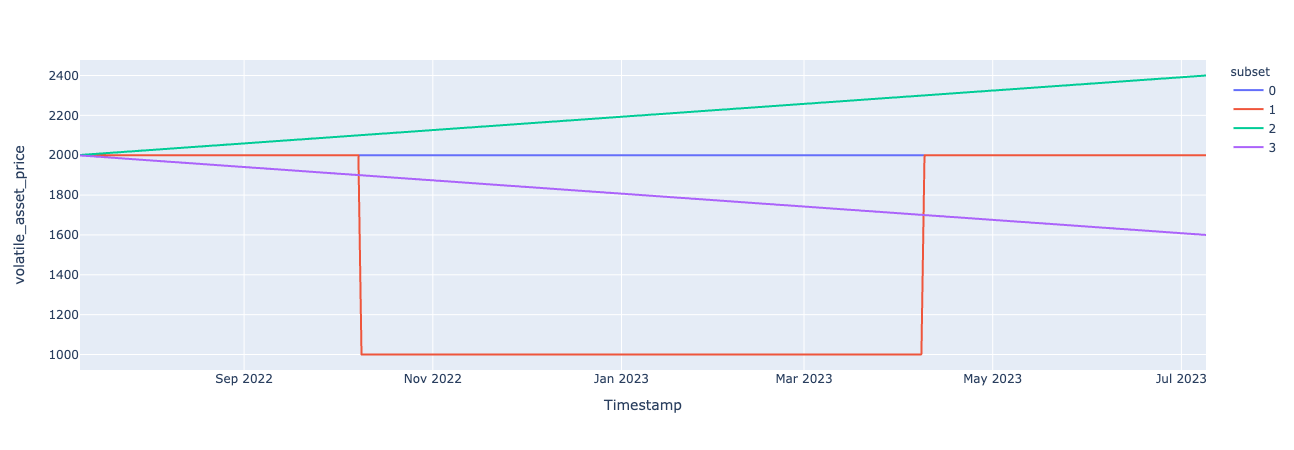

time: 923 ms (started: 2022-07-09 22:49:03 -04:00)


In [8]:
fig = df.plot(y='volatile_asset_price', color='subset')

fig.update_xaxes(title='Timestamp')

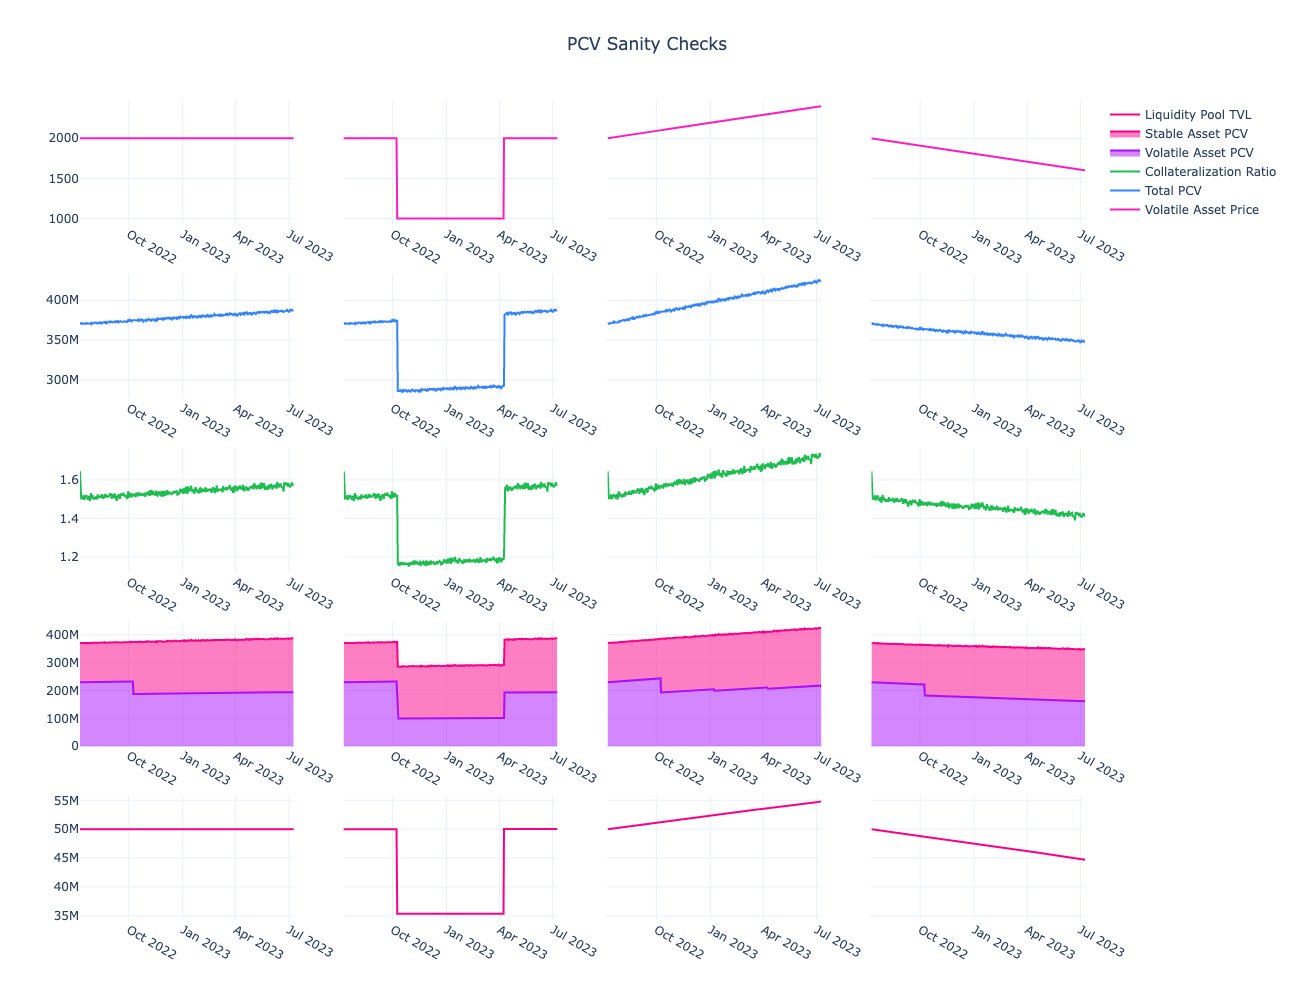

time: 835 ms (started: 2022-07-09 22:49:04 -04:00)


In [9]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import itertools
from experiments.notebooks.visualizations.plotly_theme import cadlabs_colorway_sequence
color_cycle = itertools.cycle(cadlabs_colorway_sequence)


fig = make_subplots(rows=5, cols=len(df.subset.unique()), shared_yaxes=True)

for subset in df.subset.unique():
    df_plot = df.query('subset == @subset')
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.volatile_asset_price,
            name="Volatile Asset Price",
            line=dict(color=cadlabs_colorway_sequence[0]),
            showlegend=(True if subset == 0 else False),
        ),
        row=1, col=subset+1,
    )

    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_pcv,
            name="Total PCV",
            line=dict(color=cadlabs_colorway_sequence[1]),
            showlegend=(True if subset == 0 else False),
        ),
        row=2, col=subset+1
    )

    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.collateralization_ratio,
            name="Collateralization Ratio",
            line=dict(color=cadlabs_colorway_sequence[2]),
            showlegend=(True if subset == 0 else False),
        ),
        row=3, col=subset+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_volatile_asset_pcv,
            name="Volatile Asset PCV",
            line=dict(color=cadlabs_colorway_sequence[3]),
            showlegend=(True if subset == 0 else False),
            stackgroup='one',
        ),
        row=4, col=subset+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.total_stable_asset_pcv,
            name="Stable Asset PCV",
            line=dict(color=cadlabs_colorway_sequence[4]),
            showlegend=(True if subset == 0 else False),
            stackgroup='one',
        ),
        row=4, col=subset+1
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_plot.timestamp,
            y=df_plot.liquidity_pool_tvl,
            name="Liquidity Pool TVL",
            line=dict(color=cadlabs_colorway_sequence[4]),
            showlegend=(True if subset == 0 else False),
        ),
        row=5, col=subset+1
    )


fig.update_layout(height=1000, title_text="PCV Sanity Checks")
fig.show()

# Analysis 2: Correlation Matrix

In [10]:
# Analysis-specific setup
simulation_2.model.params.update({})

time: 34.3 ms (started: 2022-07-09 22:49:05 -04:00)


In [11]:
# Experiment execution
df_2, exceptions = run(simulation_2)

2022-07-09 22:49:05,852 - root - INFO - Running experiment
2022-07-09 22:49:05,854 - root - INFO - Setting up initial state
2022-07-09 22:49:05,858 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-07-09 22:49:06,836 - root - INFO - Experiment complete in 0.9832019805908203 seconds
2022-07-09 22:49:06,837 - root - INFO - Post-processing results
2022-07-09 22:49:07,335 - root - INFO - Post-processing complete in 0.49838900566101074 seconds
time: 1.51 s (started: 2022-07-09 22:49:05 -04:00)


In [12]:
# Post-processing and visualizations

time: 28.1 ms (started: 2022-07-09 22:49:07 -04:00)


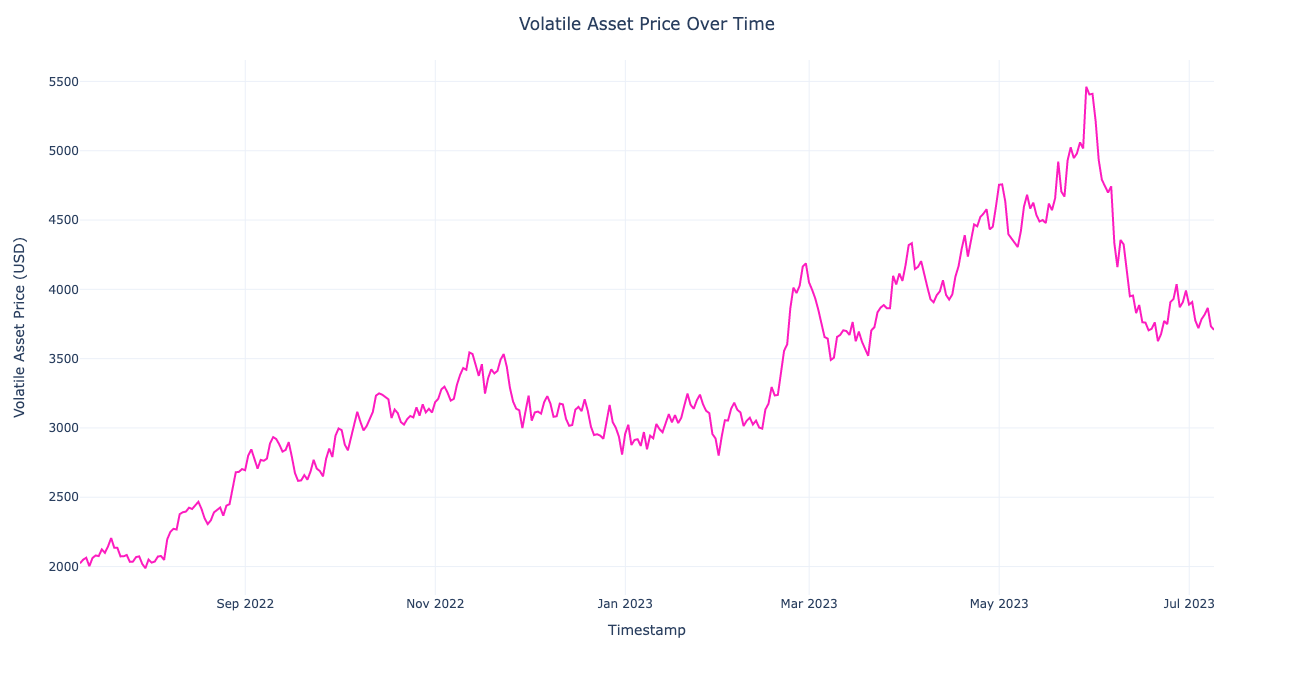

time: 90.5 ms (started: 2022-07-09 22:49:07 -04:00)


In [13]:
fig = df_2.plot(y="volatile_asset_price")
fig.update_layout(
    title="Volatile Asset Price Over Time",
    xaxis_title="Timestamp",
    yaxis_title="Volatile Asset Price (USD)",
    autosize=False,
    width=1200,
    height=675,
)
fig.show()

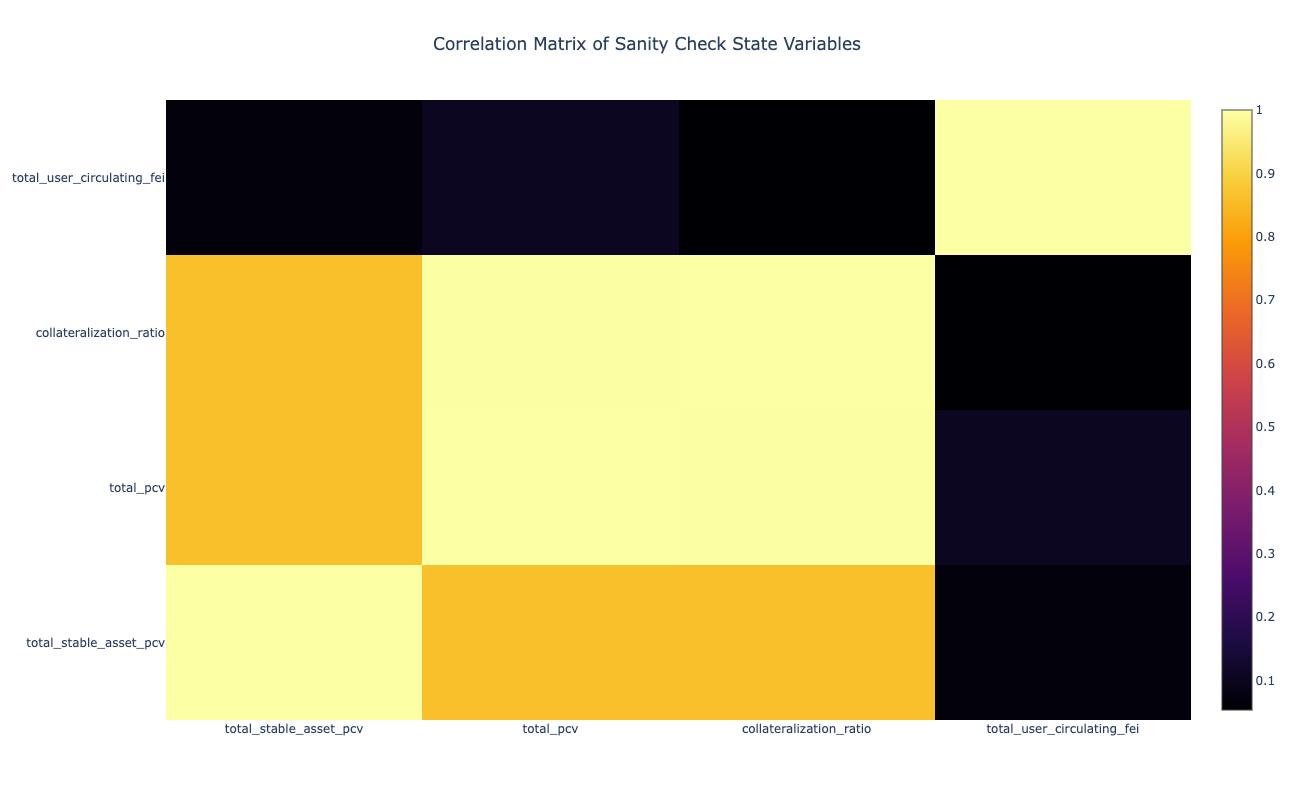

time: 40.4 ms (started: 2022-07-09 22:49:07 -04:00)


In [14]:
variables = [
    "total_stable_asset_pcv",
    "total_pcv",
    "collateralization_ratio",
    "total_user_circulating_fei",
]

z = df_2[variables].corr().values.tolist()

fig = go.Figure(data=go.Heatmap(
        z=z,
        x=variables,
        y=variables,
        colorscale='Inferno'
    )
)

fig.update_layout(
    title="Correlation Matrix of Sanity Check State Variables",
    autosize=False,
    width=800,
    height=800,
)

fig.show()

In [15]:
def plot_states_vs_volatile_asset_price(df):
    fig_1 = px.scatter(df, x='volatile_asset_price', y='total_pcv', color='timestep')
    fig_1.update_layout(
        title="PCV vs. Volatile Asset Price",
        autosize=False,
        width=800,
        height=800,
    )
    fig_1.update_xaxes(title="Volatile Asset Price (USD)")
    fig_1.update_yaxes(title="PCV (USD)")
    fig_1.show()
    
    fig_2 = px.scatter(df, x='volatile_asset_price', y='collateralization_ratio_pct', color='timestep')
    fig_2.update_layout(
        title="Collateralization Ratio vs. Volatile Asset Price",
        autosize=False,
        width=800,
        height=800,
    )
    fig_2.update_xaxes(title="Volatile Asset Price (USD)")
    fig_2.update_yaxes(title="Collateralization Ratio (%)")
    fig_2.show()
    
    fig_3 = px.scatter(df, x='volatile_asset_price', y='total_user_circulating_fei', color='timestep')
    fig_3.update_layout(
        title="User-circulating FEI vs. Volatile Asset Price",
        autosize=False,
        width=800,
        height=800,
    )
    fig_3.update_xaxes(title="Volatile Asset Price (USD)")
    fig_3.update_yaxes(title="User-circulating FEI (USD)")
    fig_3.show()

time: 30.9 ms (started: 2022-07-09 22:49:07 -04:00)


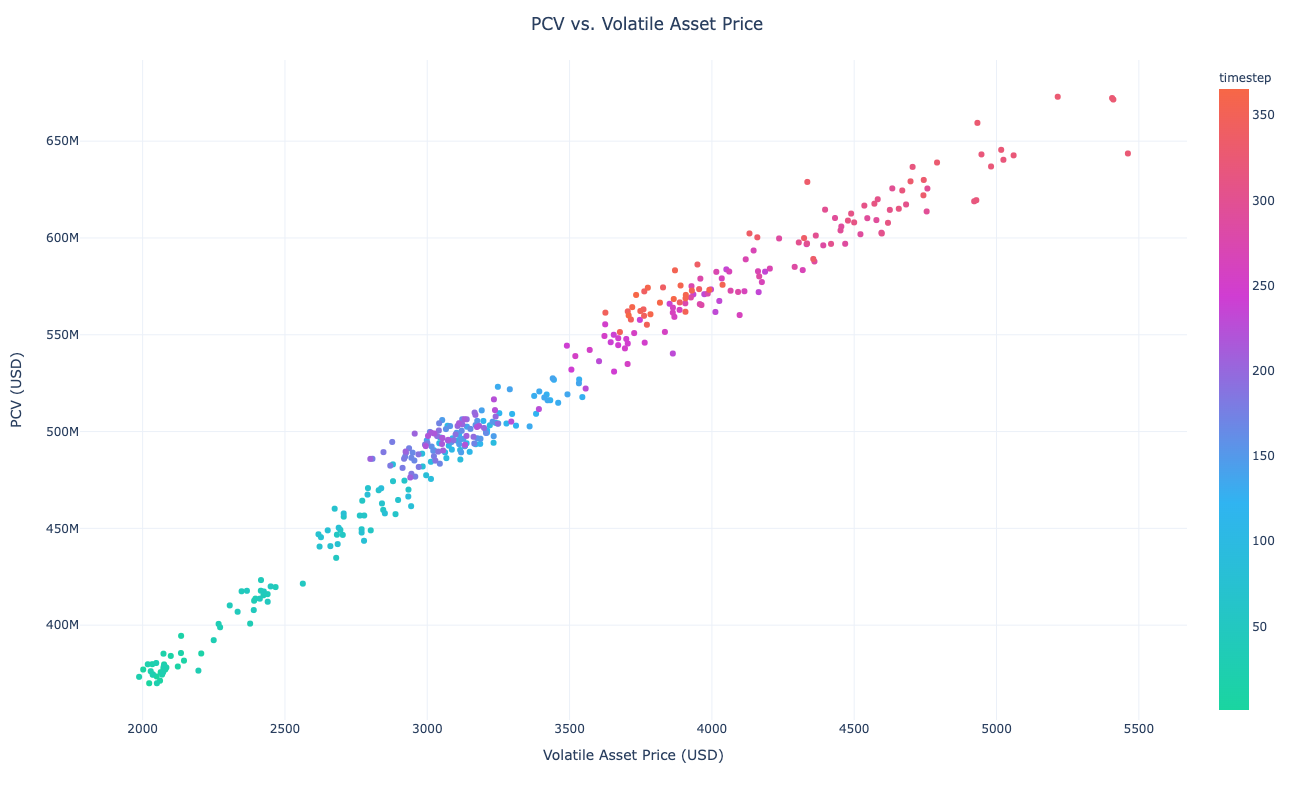

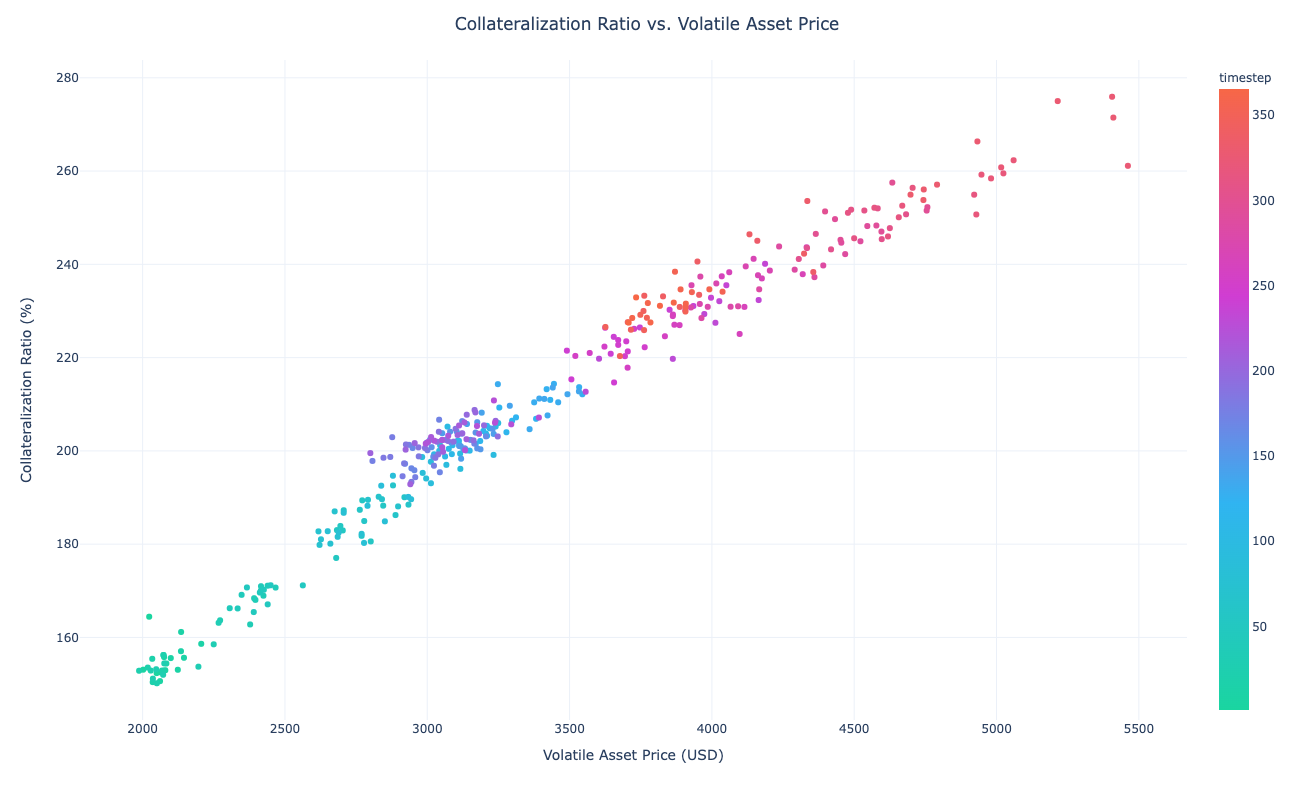

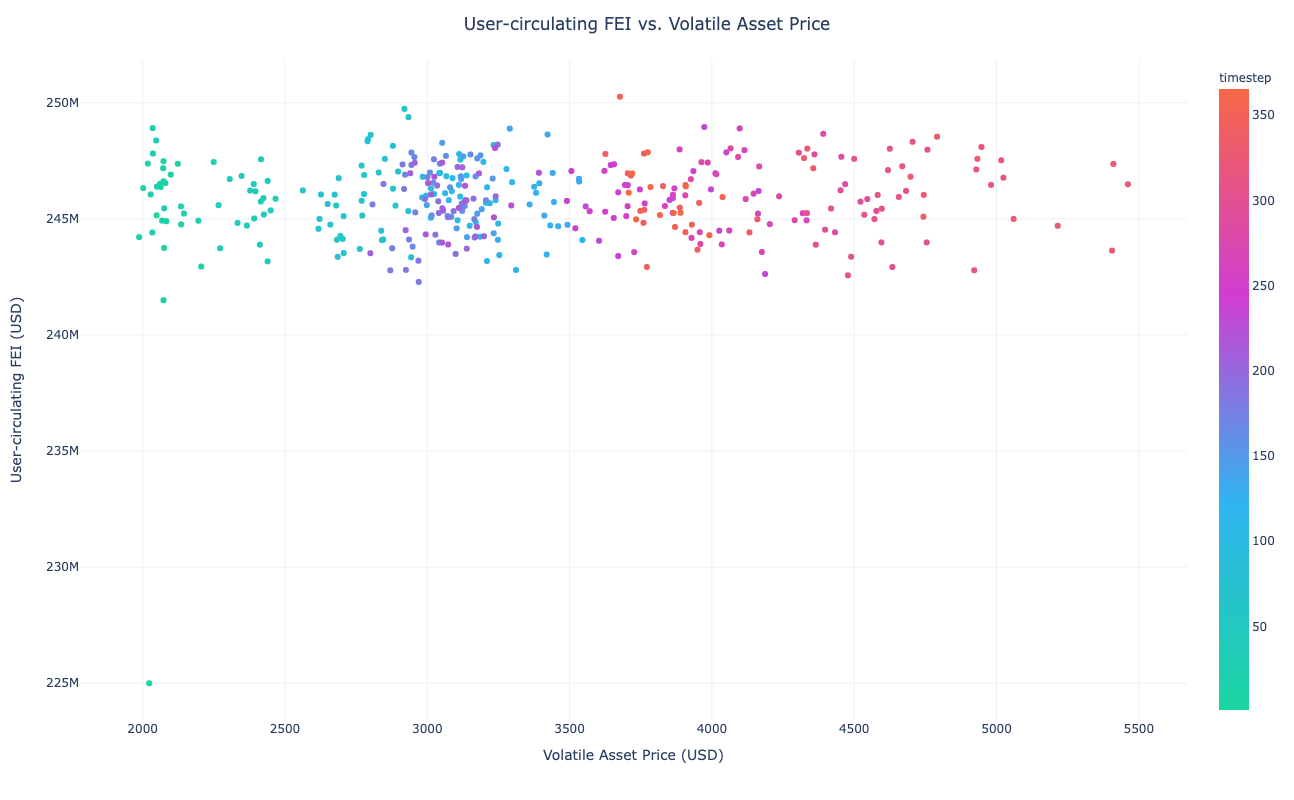

time: 215 ms (started: 2022-07-09 22:49:07 -04:00)


In [16]:
plot_states_vs_volatile_asset_price(df_2)

# Analysis 3: PCV at Risk

## Risk Analysis Methodology

The goal of the FEI Ecosystem Model Risk Analysis is to provide qualitative and quantitative recommendations to surface the most appropriate FEI monetary policy parameter settings across multiple scenarios. The risk analysis includes a cohesive set of model metrics, risk scores and protocol KPIs.

The main holistic risk analysis and parameter recommendation tool at our disposal is the FEI Capital Allocation model, where we allow the model to provide risk-weighted target allocations of FEI in all modeled avenues for FEI liquidity - LP, MM, FSD, Idle. These allocation targets will depend on parameter sweeps of FEI's monetary policy levers such as the FEI Savings Rate (see simplified ERD). The highest scoring parameter settings in terms of FEI Capital allocation and associated comparative KPIs will form the quantitative basis for recommendations.

It is to be noted that we can analyze KPIs comparatively based on monetary policy parameter settings in <b>Two ways</b> - qualitative/deterministic, and statistically based/stochastic.

Since the main driver of volatility in the FEI ecosystem is the Volatile Asset (an abstraction for Ethereum), we can model this volatile asset as Trajectory-based (based on a linear function), or based on a stochastic process such as a Geometric Brownian motion. The application of both settings for the Volatile asset allows us to respectively perform two analysis types.

1. Qualitative recommendations can be made as a result of comparative KPI analysis across different monetary policy parameter settings, using a trajectory model for the Volatile Asset. These do NOT involve monte carlo runs. The output of these analyses is to understand the impact on KPIs as a result of monetary policy changes for various final levels of Volatile Asset price. Ex: For a 30% VA price downturn, Stable backing ratio is higher with monetary policy 1 than policy 2, ie: Delta_1,2 Stable Backing ratio > 0, hence policy 1 is recommended.


2. Statistically-based recommendations can be made as a result of comparative KPI analysis across different monetary policy parameter settings, using a parameterized stochastic model for the Volatile Asset. These DO involve monte carlo runs. The output of these analyses is to construct a probability distribution for each KPI from which summary statistics can be derived. This allows us to empirically say that for a given parameter setting, KPIs are above or below key thresholds with a certain probability. Ex: Over 1000 simulations, 1-Day PCV at Risk is < 1M USD with a 90% probability with policy 1 and < 1M USD with an 85% probability with policy 2. Additionally, the statistical average PCVaR is lower with policy 1 than with policy 2, ie: Delta_1,2 avg. PCVaR > 0. Hence policy 1 is recommended.


## Analysis Summary

In this analysis, which is based on a stochastic Volatile Asset Price process with 10 realizations (10 monte carlo runs), we look at two policies (a parameter sweep of size 2) and look at the empirical probability of the PCV at Risk KPI being below a certain threshold, as well as comparatively examine the value of the KPI across both policies to yield a recommendation.

In [17]:
from operator import lt, gt


simulation_3.runs = 10

parameter_overrides = {
    "target_rebalancing_condition": [gt, lt], # Simulate decrease and increase of stable PCV
    "target_stable_pcv_ratio": [0.2, 0.5], # Simulate decrease and increase of stable PCV
    "rebalancing_period": [int(365 / 4)],
}

simulation_3.model.params.update(parameter_overrides)

time: 32 ms (started: 2022-07-09 22:49:07 -04:00)


In [18]:
# Experiment execution
df_3, exceptions = run(simulation_3)

2022-07-09 22:49:07,848 - root - INFO - Running experiment
2022-07-09 22:49:07,850 - root - INFO - Setting up initial state
2022-07-09 22:49:07,854 - root - INFO - Starting simulation 0 / run 0 / subset 0
2022-07-09 22:49:08,854 - root - INFO - Setting up initial state
2022-07-09 22:49:08,858 - root - INFO - Starting simulation 0 / run 0 / subset 1
2022-07-09 22:49:09,898 - root - INFO - Setting up initial state
2022-07-09 22:49:09,902 - root - INFO - Starting simulation 0 / run 1 / subset 0
2022-07-09 22:49:10,869 - root - INFO - Setting up initial state
2022-07-09 22:49:10,873 - root - INFO - Starting simulation 0 / run 1 / subset 1
2022-07-09 22:49:11,905 - root - INFO - Setting up initial state
2022-07-09 22:49:11,909 - root - INFO - Starting simulation 0 / run 2 / subset 0
2022-07-09 22:49:12,390 - root - WARNING - Cashing out of yield-bearing deposit
2022-07-09 22:49:12,649 - root - WARNING - Cashing out of yield-bearing deposit
2022-07-09 22:49:12,910 - root - INFO - Setting up 

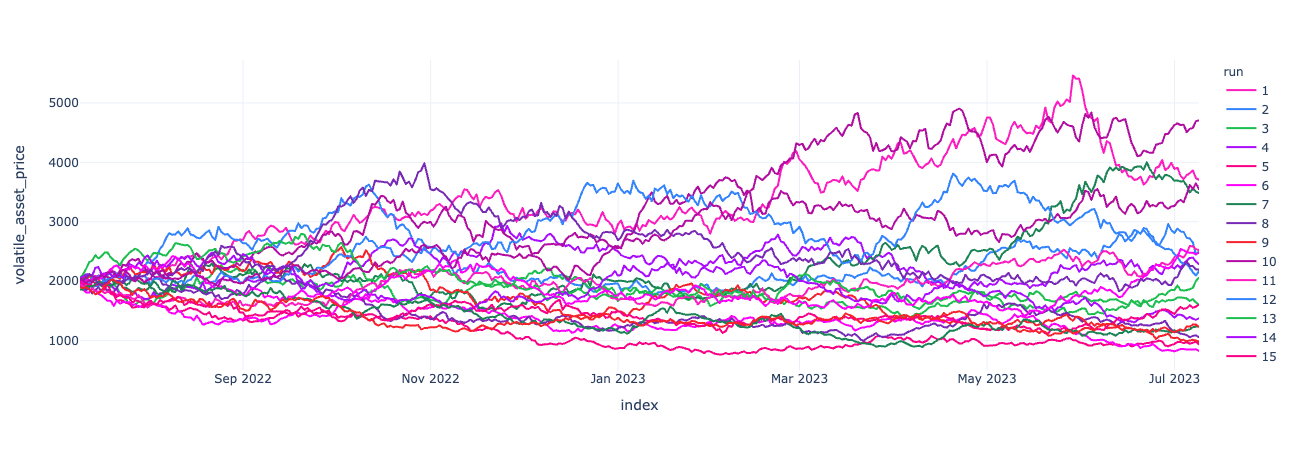

time: 501 ms (started: 2022-07-09 22:50:05 -04:00)


In [19]:
df_3.query('subset == 0').plot(y="volatile_asset_price", color="run")

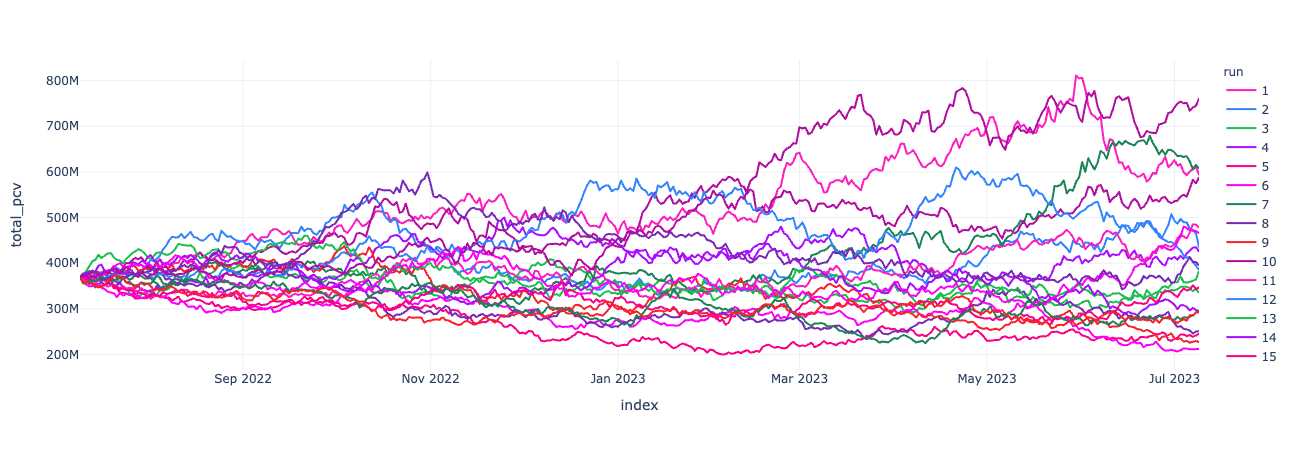

time: 512 ms (started: 2022-07-09 22:50:06 -04:00)


In [20]:
df_3.query('subset == 0').plot(y="total_pcv", color="run")

## PCV at Risk Calculation Across All Subsets and Runs

In [21]:
import numpy as np


def calculate_VaR(df, state_variable, alpha, timesteps):
    results = pd.DataFrame()

    for simulation in df.simulation.unique():
        df_simulation = df.query("simulation == @simulation")
        for subset in df_simulation.subset.unique():
            df_subset = df_simulation.query("subset == @subset")
            for run in df_subset.run.unique():
                df_run = df_subset.query("run == @run")

                returns = df_run[state_variable].pct_change()
                final_value = df_run[state_variable].iloc[-1]
                q = returns.quantile(1 - alpha)
                value_at_risk = abs(final_value * q) * np.sqrt(timesteps)

                result = pd.DataFrame({'simulation': [simulation], 'subset': [subset], 'run': [run], 'VaR': [value_at_risk], 'q': [q]})
                results = pd.concat([results, result])

    return results.reset_index(drop=True)

time: 33.3 ms (started: 2022-07-09 22:50:06 -04:00)


In [22]:
df_var = calculate_VaR(df_3, "total_pcv", alpha=0.95, timesteps=1)
df_var

simulation  subset  run           VaR         q
0            0       0    1  1.928786e+07 -0.032480
1            0       0    2  1.179680e+07 -0.027064
2            0       0    3  9.510167e+06 -0.028351
3            0       0    4  1.295856e+07 -0.030433
4            0       0    5  7.487738e+06 -0.030496
5            0       0    6  6.698661e+06 -0.031518
6            0       0    7  1.789686e+07 -0.029442
7            0       0    8  7.160110e+06 -0.028491
8            0       0    9  7.761985e+06 -0.034154
9            0       0   10  1.870624e+07 -0.031843
10           0       0   11  1.408402e+07 -0.029491
11           0       0   12  1.169492e+07 -0.030299
12           0       0   13  1.104930e+07 -0.028898
13           0       0   14  8.962216e+06 -0.030347
14           0       0   15  1.006744e+07 -0.029022
15           0       0   16  1.299063e+07 -0.027878
16           0       0   17  8.551539e+06 -0.029035
17           0       0   18  1.176211e+07 -0.029733
18           0       0   19  7.892326e+06 -0.027009
19           0       0   20  2.082639e+07 -0.027379
20           0       1    1  1.147238e+07 -0.020488
21           0       1    2  8.393142e+06 -0.017815
22           0       1    3  8.049863e+06 -0.022668
23           0       1    4  8.638772e+06 -0.020360
24           0       1    5  5.640189e+06 -0.020437
25           0       1    6  4.904969e+06 -0.018202
26           0       1    7  1.090052e+07 -0.021313
27           0       1    8  5.617507e+06 -0.019082
28           0       1    9  6.417608e+06 -0.020760
29           0       1   10  1.247640e+07 -0.022816
30           0       1   11  9.127433e+06 -0.020990
31           0       1   12  8.563820e+06 -0.019739
32           0       1   13  8.195584e+06 -0.020635
33           0       1   14  7.154150e+06 -0.021542
34           0       1   15  7.163269e+06 -0.021261
35           0       1   16  8.093690e+06 -0.018981
36           0       1   17  5.810761e+06 -0.019221
37           0       1   18  9.461626e+06 -0.020841
38           0       1   19  6.555426e+06 -0.021418
39           0       1   20  1.067199e+07 -0.017539

time: 388 ms (started: 2022-07-09 22:50:06 -04:00)


In [23]:
df_var.query("subset == 0")[["VaR", "q"]].describe()

VaR          q
count  2.000000e+01  20.000000
mean   1.185729e+07  -0.029668
std    4.325401e+06   0.001853
min    6.698661e+06  -0.034154
25%    8.386736e+06  -0.030449
50%    1.137211e+07  -0.029467
75%    1.326398e+07  -0.028456
max    2.082639e+07  -0.027009

time: 43.2 ms (started: 2022-07-09 22:50:07 -04:00)


In [24]:
print(f"1-day average PCV at Risk at 95th quantile for subset 0: \n {df_var_stats_0['VaR'].loc['mean']:,.2f} USD")

NameError: name 'df_var_stats_0' is not defined

time: 716 ms (started: 2022-07-09 22:50:07 -04:00)


In [ ]:
df_var.query("subset == 1")[["VaR", "q"]].describe()

In [ ]:
print(f"1-day average PCV at Risk at 95th quantile for subset 1: \n {df_var_stats_1['VaR'].loc['mean']:,.2f} USD")

## 1-day PCV at Risk for Policy 0

A visualization of PCVaR calculation for one monte carlo run for one Policy (parameter setting).

In [ ]:
pcv_ret = df_3.query('run == 1 and subset == 0')['total_pcv'].pct_change()
var = df_var.query('run == 1 and subset == 0')['VaR'].iloc[0]
q = df_var.query('run == 1 and subset == 0')['q'].iloc[0]

fig = px.histogram(pcv_ret, x="total_pcv", title="Histogram of PCV Returns for Run 1, Policy 0")
fig.add_vline(x=q)
fig.show()

print(f'1-Day PCVar for Run 1, Policy 0 (Subset 0) is {var:,.2f} USD with 5% quantile value {100*q:.2f}%')

## Probability of PCV at Risk Being Below Threshold Analysis

In [ ]:
quantile_return_threshold = -0.02


def calculate_VaR_threshold_probability(df, threshold):
    results = pd.DataFrame()
    
    for subset in df.subset.unique():
        df_subset = df.query("subset == @subset")
        
        df_threshold = df_subset["q"] <= threshold
        probability = df_threshold.sum() / len(df_threshold)
        
        result = pd.DataFrame({'subset': [subset], 'threshold': [threshold], 'probability': [probability]})
        results = pd.concat([results, result])
    
    return results.reset_index(drop=True)

In [ ]:
q_probabilities = calculate_VaR_threshold_probability(df_var, threshold=quantile_return_threshold)

In [ ]:
for subset in q_probabilities.subset.unique():
    print(f"""For Policy {subset + 1}, the 1-Day PCV at Risk is less than {abs(quantile_return_threshold*100)}% with a {100*q_probabilities.query('subset == @subset')['probability'].iloc[0]}% probability""")

From this analysis, we see that over the 10 monte carlo runs for each policy (each subset), since the probability of PCV at risk being less than 2% of total PCV on any given day is lower for policy 1 than for policy 2, policy 1 does a better job at risk mitigation, hence we recommend policy 1.

## Comparative PCV at Risk Analysis

In [ ]:
avg_VaR_delta = df_var_stats_0['VaR'].loc['mean'] - df_var_stats_1['VaR'].loc['mean']
avg_VaR_quantile_delta = df_var_stats_0['q'].loc['mean'] - df_var_stats_1['q'].loc['mean']

In [ ]:
print(f"The Average PCVaR Delta between parameter for policies 1 and 2 is: \n {avg_VaR_delta:,} USD")

In [ ]:
print(f"The Average PCVaR Quantile Delta between parameter for policies 1 and 2 is: \n {avg_VaR_quantile_delta:,}")

We conclude that while the 1-Day PCVaR is greater for policy 1 than for policy 2, meaning more PCV is at risk on any given day at a 95% quantile, the value of this quantile is lower, meaning the PCV has a lower magnitude of negative returns, attesting to the risk mitigating effect of policy 1. Hence, policy 1 is recommended.

# Analysis 4: Capital Allocation Metrics

In [ ]:
fei_capital_allocation_variables = [
    'fei_deposit_idle_balance',
    'fei_deposit_liquidity_pool_balance',
    'fei_deposit_money_market_balance'
]
fei_capital_allocation_variables.sort()

In [ ]:
import plotly.express as px

px.area(df_2, y=fei_capital_allocation_variables, groupnorm='percent')

In [ ]:
df_allocations = df[fei_capital_allocation_variables].iloc[-1]

px.pie(df_allocations.sort_index(), values=df_allocations.values, names=df_allocations.index)

# Appendix

In [ ]:
_df = df.groupby(['subset','timestep']).mean().query('subset == 0')
stats_df = _df.describe()
stats_df.loc['skew'] = _df.skew()
stats_df.loc['kurtosis'] = _df.kurtosis()
# TODO: max drawdown & other relevant summary stats here

stats_df

In [ ]:
fig = df_2.plot(y="collateralization_ratio_pct")
fig.add_hline(y=150)
fig.update_layout(
    title="Collateralization Ratio Over Time",
    xaxis_title="Timestamp",
    yaxis_title="Collateralization Ratio (%)",
    autosize=False,
    width=1200,
    height=675,
)
fig.show()

In [ ]:
fig = df_2.plot(y="stable_backing_ratio_pct")
fig.add_hline(y=70)
fig.show()

In [ ]:
fig = df_2.plot(y="stable_pcv_ratio_pct")
fig.add_hline(y=50)
fig.show()

In [ ]:
df_2.plot(y="pcv_yield_rate_pct")

fig.update_layout(
    title="PCV Yield Rate",
)
fig.update_xaxes(title="Timestamp")
fig.update_yaxes(title="PCV Yield Rate (%)")
fig.show()

In [ ]:
fig = df_2.plot(y="pcv_yield_ratio_pct")

fig.update_layout(
    title="PCV Yield Ratio",
)
fig.update_xaxes(title="Timestamp")
fig.update_yaxes(title="PCV Yield Ratio (%)")
fig.show()

In [ ]:
fig = df_2.plot(y="protocol_equity")

fig.update_layout(
    title="Protocol Equity",
)
fig.update_xaxes(title="Timestamp")
fig.update_yaxes(title="Protocol Equity (USD)")
fig.show()